In [6]:
import numpy as np
import matplotlib.pyplot as plt
import os
import fitsio
import glob

In [7]:
def compute_entropy_1d(x):
    n_steps = len(x)//4 - 1
    proba = {}
    for i in range(n_steps):
        d = x[i*4:(i+1)*4]
        l = list(np.argsort(d))
        l = ''.join(str(e) for e in l)
        try:
            proba[l] += 1
        except:
            proba[l] = 1
    p = np.array(list(proba.values()))
    p = p/p.sum()
    h = np.sum(-p*np.log2(p))/np.log2(24)
    return h

In [3]:
fuji_path = "/global/cfs/cdirs/desi/spectro/redux/fuji/"

In [11]:
search_path = "{}/tiles/cumulative/{}/*/redrock-0-{}-thru*.fits".format(fuji_path, tile_id, tile_id)
file_in = glob.glob(search_path)


print(search_path)
print(file_in)

/global/cfs/cdirs/desi/spectro/redux/fuji//tiles/cumulative/500/*/redrock-0-500-thru*.fits
['/global/cfs/cdirs/desi/spectro/redux/fuji//tiles/cumulative/500/20210510/redrock-0-500-thru20210510.fits']


In [16]:
petal_id = 3
tile_id = 460
for petal_id in range(10):
    search_path = "{}/tiles/cumulative/{}/*/redrock-0-{}-thru*.fits".format(fuji_path, tile_id, tile_id)
    file_in = glob.glob(search_path)
    tile_file = file_in[0].replace("redrock-0", "redrock-{}".format(petal_id))
    z_tile_per_exp = fitsio.read(tile_file, ext="REDSHIFTS")
    fmap_tile_per_exp = fitsio.read(tile_file, ext="FIBERMAP")
    exp_fmap_tile_per_exp = fitsio.read(tile_file, ext="EXP_FIBERMAP")
    ii = (z_tile_per_exp['ZWARN']==0) & (exp_fmap_tile_per_exp['FIBERSTATUS']==0)
    #print(np.count_nonzero(ii))
    #plt.plot(z_tile_per_exp['Z'][ii])
    h = compute_entropy_1d(z_tile_per_exp['Z'][ii])
    n_gal = np.count_nonzero(z_tile_per_exp['SPECTYPE'][ii]=='GALAXY')
    n_star = np.count_nonzero(z_tile_per_exp['SPECTYPE'][ii]=='STAR')
    n_qso = np.count_nonzero(z_tile_per_exp['SPECTYPE'][ii]=='QSO')
    print(petal_id, h, n_gal, n_star, n_qso)

0 0.9580146001474078 306 17 26
1 0.958026381015426 276 10 21
2 0.951767145107896 314 16 24
3 0.9424394447318519 278 11 22
4 0.9685334969884569 272 13 34
5 0.9329327251121758 277 14 28
6 0.9487761588856332 240 16 29
7 0.9647553332084833 243 12 22
8 0.919481098207059 271 12 27
9 0.9541712147699525 273 18 18


112
27
0.8301883164383251


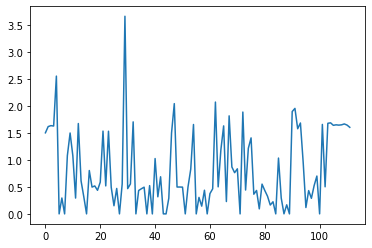

In [85]:
#[('TARGETID', '>i8'), ('Z', '>f8'), ('ZERR', '>f8'), ('ZWARN', '>i8'), ('CHI2', '>f8'), ('COEFF', '>f8', (10,)), ('NPIXELS', '>i8'), 
# ('SPECTYPE', '<U6'), ('SUBTYPE', '<U20'), ('NCOEFF', '>i8'), ('DELTACHI2', '>f8')])


In [47]:
len(z_tile_per_exp['Z'])

500

In [48]:
list(z_tile_per_exp['SPECTYPE'][ii])

['QSO',
 'GALAXY',
 'GALAXY',
 'GALAXY',
 'QSO',
 'STAR',
 'GALAXY',
 'STAR',
 'QSO',
 'QSO',
 'QSO',
 'GALAXY',
 'QSO',
 'GALAXY',
 'GALAXY',
 'STAR',
 'GALAXY',
 'GALAXY',
 'GALAXY',
 'GALAXY',
 'GALAXY',
 'QSO',
 'GALAXY',
 'QSO',
 'GALAXY',
 'GALAXY',
 'GALAXY',
 'STAR',
 'GALAXY',
 'QSO',
 'GALAXY',
 'GALAXY',
 'QSO',
 'STAR',
 'GALAXY',
 'GALAXY',
 'GALAXY',
 'STAR',
 'GALAXY',
 'STAR',
 'GALAXY',
 'GALAXY',
 'GALAXY',
 'STAR',
 'STAR',
 'GALAXY',
 'QSO',
 'QSO',
 'GALAXY',
 'GALAXY',
 'GALAXY',
 'STAR',
 'GALAXY',
 'GALAXY',
 'GALAXY',
 'STAR',
 'GALAXY',
 'GALAXY',
 'GALAXY',
 'STAR',
 'GALAXY',
 'GALAXY',
 'QSO',
 'GALAXY',
 'GALAXY',
 'GALAXY',
 'GALAXY',
 'QSO',
 'GALAXY',
 'GALAXY',
 'GALAXY',
 'STAR',
 'QSO',
 'GALAXY',
 'GALAXY',
 'QSO',
 'GALAXY',
 'GALAXY',
 'GALAXY',
 'GALAXY',
 'GALAXY',
 'GALAXY',
 'GALAXY',
 'GALAXY',
 'STAR',
 'GALAXY',
 'GALAXY',
 'STAR',
 'GALAXY',
 'STAR',
 'QSO',
 'QSO',
 'GALAXY',
 'GALAXY',
 'GALAXY',
 'GALAXY',
 'GALAXY',
 'GALAXY',
 'GALAXY

In [26]:
fmap_tile_per_exp.dtype

dtype([('TARGETID', '>i8'), ('PETAL_LOC', '>i2'), ('DEVICE_LOC', '>i4'), ('LOCATION', '>i8'), ('FIBER', '>i4'), ('COADD_FIBERSTATUS', '>i4'), ('TARGET_RA', '>f8'), ('TARGET_DEC', '>f8'), ('PMRA', '>f4'), ('PMDEC', '>f4'), ('REF_EPOCH', '>f4'), ('LAMBDA_REF', '>f4'), ('FA_TARGET', '>i8'), ('FA_TYPE', 'u1'), ('OBJTYPE', '<U3'), ('FIBERASSIGN_X', '>f4'), ('FIBERASSIGN_Y', '>f4'), ('PRIORITY', '>i4'), ('SUBPRIORITY', '>f8'), ('OBSCONDITIONS', '>i4'), ('RELEASE', '>i2'), ('BRICKNAME', '<U8'), ('BRICKID', '>i4'), ('BRICK_OBJID', '>i4'), ('MORPHTYPE', '<U4'), ('EBV', '>f4'), ('FLUX_G', '>f4'), ('FLUX_R', '>f4'), ('FLUX_Z', '>f4'), ('FLUX_W1', '>f4'), ('FLUX_W2', '>f4'), ('FLUX_IVAR_G', '>f4'), ('FLUX_IVAR_R', '>f4'), ('FLUX_IVAR_Z', '>f4'), ('FLUX_IVAR_W1', '>f4'), ('FLUX_IVAR_W2', '>f4'), ('FIBERFLUX_G', '>f4'), ('FIBERFLUX_R', '>f4'), ('FIBERFLUX_Z', '>f4'), ('FIBERTOTFLUX_G', '>f4'), ('FIBERTOTFLUX_R', '>f4'), ('FIBERTOTFLUX_Z', '>f4'), ('MASKBITS', '>i2'), ('SERSIC', '>f4'), ('SHAPE_R', '

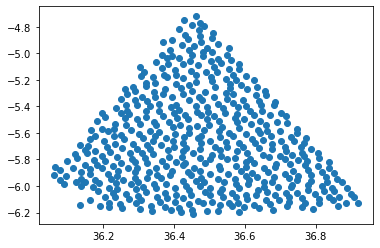

In [29]:
plt.scatter(fmap_tile_per_exp['TARGET_RA'], fmap_tile_per_exp['TARGET_DEC'])

In [31]:
exp_fmap_tile_per_exp['FIBERSTATUS']

array([1024,    0,    0,    0,    0, 1024,    0,    0, 1024,    0,    0,
          0,    0,    0,    0,    0, 1024,    0,    0, 1024,    0,    0,
       1024,    0,    0,    0, 1024, 1024,    0,    0, 1024,    0,    0,
          0,    0,    0, 1024, 1024, 1024,    0,    0,    0,    0,    0,
          0,    0, 1024, 1024,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0, 1024, 1024,    0,    0, 1024,    0,    0,    0,
          0,    0, 1024, 1024,    0, 1024, 1024,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0, 1024,    0, 1024,    0,
          0, 1024, 1024,    0, 1024,    0,    0, 1024, 1024,    0,    0,
          0, 1024,    0, 1024,    0,    0,    0,   